# Machine Learning and Prediction in Python

As noted in the Stata part of the lab, Python has a number of very powerful machine learning libraries. In this part of the lab, we will use the `scikit-learn` library to perform a number of machine learning tasks. 

`scikit-learn` makes it very easy to perform machine learning tasks. The library is very well documented and has a number of examples that you can use to learn how to use the library.

This notebook accompanies the Stata part of the lab. We'll work though what a typical machine learning workflow looks like in Python. We'll use the same data as in the STATA part of the lab. Highlighting the key points of tuning parameter selection by cross-validation and model evaluation through out-of-sample accuracy.

The steps we'll go through are:

1. Load and prepare the data
2. Split the data into training and test sets
3. Train a model on the training set
4. Evaluate the model on the test set
5. Use the model to make predictions
6. Save the model


### 1. Load and prepare the data

We will again use the kielmc dataset. The dataset covers house sales and the prediction task is to predict the log sales price based on some house characteristics: number of rooms and bathrooms, the age and the area of the house, and the land area of the property where the house is located.

In [40]:
import numpy as np             
import pandas as pd             
import matplotlib.pyplot as plt 

# load and prepare the data
url = "http://fmwww.bc.edu/ec-p/data/wooldridge/kielmc.dta"
data = pd.read_stata(url)

# keep if year==1981
# data = data[data['year'] == 1981]

# Display basic information about the dataset
data.info()

# View the first 5 rows of the data
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      321 non-null    float32
 1   age       321 non-null    float32
 2   agesq     321 non-null    float32
 3   nbh       321 non-null    float32
 4   cbd       321 non-null    float32
 5   intst     321 non-null    float32
 6   lintst    321 non-null    float32
 7   price     321 non-null    float32
 8   rooms     321 non-null    float32
 9   area      321 non-null    float32
 10  land      321 non-null    float32
 11  baths     321 non-null    float32
 12  dist      321 non-null    float32
 13  ldist     321 non-null    float32
 14  wind      321 non-null    float32
 15  lprice    321 non-null    float32
 16  y81       321 non-null    float32
 17  larea     321 non-null    float32
 18  lland     321 non-null    float32
 19  y81ldist  321 non-null    float32
 20  lintstsq  321 non-null    float3

,year,age,agesq,nbh,cbd,intst,lintst,price,rooms,area,...,lprice,y81,larea,lland,y81ldist,lintstsq,nearinc,y81nrinc,rprice,lrprice
0,1978.0,48.0,2304.0,4.0,3000.0,1000.0,6.9078,60000.0,7.0,1660.0,...,11.00210,0.0,7.414573,8.429017,0.0,47.717701,1.0,0.0,60000.0,11.00210
1,1978.0,83.0,6889.0,4.0,4000.0,1000.0,6.9078,40000.0,6.0,2612.0,...,10.59663,0.0,7.867871,9.032409,0.0,47.717701,1.0,0.0,40000.0,10.59663
2,1978.0,58.0,3364.0,4.0,4000.0,1000.0,6.9078,34000.0,6.0,1144.0,...,10.43412,0.0,7.042286,8.517193,0.0,47.717701,1.0,0.0,34000.0,10.43412
3,1978.0,11.0,121.0,4.0,4000.0,1000.0,6.9078,63900.0,5.0,1136.0,...,11.06507,0.0,7.035269,9.210340,0.0,47.717701,1.0,0.0,63900.0,11.06507
4,1978.0,48.0,2304.0,4.0,4000.0,2000.0,7.6009,44000.0,5.0,1868.0,...,10.69195,0.0,7.532624,9.210340,0.0,57.773682,1.0,0.0,44000.0,10.69195


We have loaded the data and filtered out observations where `year` is not equal to 1981. We can see that the dataset contains 321 observations and 25 variables. The data is all in float32 format. 

Given that all the columns have 321 non-null entries, we don't need to handle missing data.

In [41]:
# Select features and target variable
selected_features = ['year', 'age', 'rooms', 'area', 'land', 'baths', 'dist']
X = data[selected_features]
y = data['lprice']

# Display first few rows of selected features
X.head()

,year,age,rooms,area,land,baths,dist
0,1978.0,48.0,7.0,1660.0,4578.0,1.0,10700.0
1,1978.0,83.0,6.0,2612.0,8370.0,2.0,11000.0
2,1978.0,58.0,6.0,1144.0,5000.0,1.0,11500.0
3,1978.0,11.0,5.0,1136.0,10000.0,1.0,11900.0
4,1978.0,48.0,5.0,1868.0,10000.0,1.0,12100.0


Now before we perform any machine learning, let's put aside $20\%$ of our data, which we will use later to evaluate the performance of the ML models

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Preprocessing

Preprocessing is the process of transforming the raw data into a format that is best for machine learning. 

We are going to build a preprocessing pipeline that will standardise continuous variables and create dummy variables for categorical variables (this is called one-hot encoding in machine-learning jargon).

In [50]:
# Import the preprocessing functions from sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipeline for numerical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, ['age', 'area', 'land', 'dist', 'rooms']),
        ('cat', OneHotEncoder(), ['baths'])
    ])

## Hyperparameter tuning

We will compare the performance of two different models. Firstly LASSO regression and secondly a random forest. We will use cross-validation to select the best tuning parameters for each model.

Now let's build our cross validation pipeline

In [51]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

# Create pipelines for LASSO and Random Forest
pipeline_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Lasso())])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor())])

The pipline works 


Now lets define tuning parameters for each model.

In [52]:
# Define parameter grids for LASSO and Random Forest
param_grid_lasso = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10]}
param_grid_rf = {'regressor__max_depth': [None, 10, 20, 30]}

Now we can use k-fold cross-validation to select the best tuning parameters for each model.

In [54]:
# Create GridSearchCV objects
grid_search_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search_lasso.fit(X, y)
grid_search_rf.fit(X, y)

# Retrieve the best parameters
best_params_lasso = grid_search_lasso.best_params_
best_params_rf = grid_search_rf.best_params_

best_params_lasso, best_params_rf

print(f"Best parameters for LASSO: {best_params_lasso}")
print(f"Best parameters for Random Forest: {best_params_rf}")

Best parameters for LASSO: {'regressor__alpha': 0.01}
Best parameters for Random Forest: {'regressor__max_depth': 30}


3. Model Evaluation

We'll now fit the models with the best hyperparameters and evaluate their performance on the training and test sets. Specifically, we'll look at MSE and RMSE to understand the models' predictive accuracy.

In [55]:
# Update the pipelines with the best hyperparameters
pipeline_lasso.set_params(regressor__alpha=best_params_lasso['regressor__alpha'])
pipeline_rf.set_params(regressor__max_depth=best_params_rf['regressor__max_depth'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'area', 'land',
                                                   'dist', 'rooms']),
                                                 ('cat', OneHotEncoder(),
                                                  ['baths'])])),
                ('regressor', RandomForestRegressor(max_depth=30))])

In [56]:
# Train the models with best hyperparameters
pipeline_lasso.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'area', 'land',
                                                   'dist', 'rooms']),
                                                 ('cat', OneHotEncoder(),
                                                  ['baths'])])),
                ('regressor', RandomForestRegressor(max_depth=30))])

MSE on train set for LASSO: 0.06495934581850671
MSE on test set for LASSO: 0.08097191687877046
MSE on train set for Random Forest: 0.011079605909934839
MSE on test set for Random Forest: 0.07528844597336012


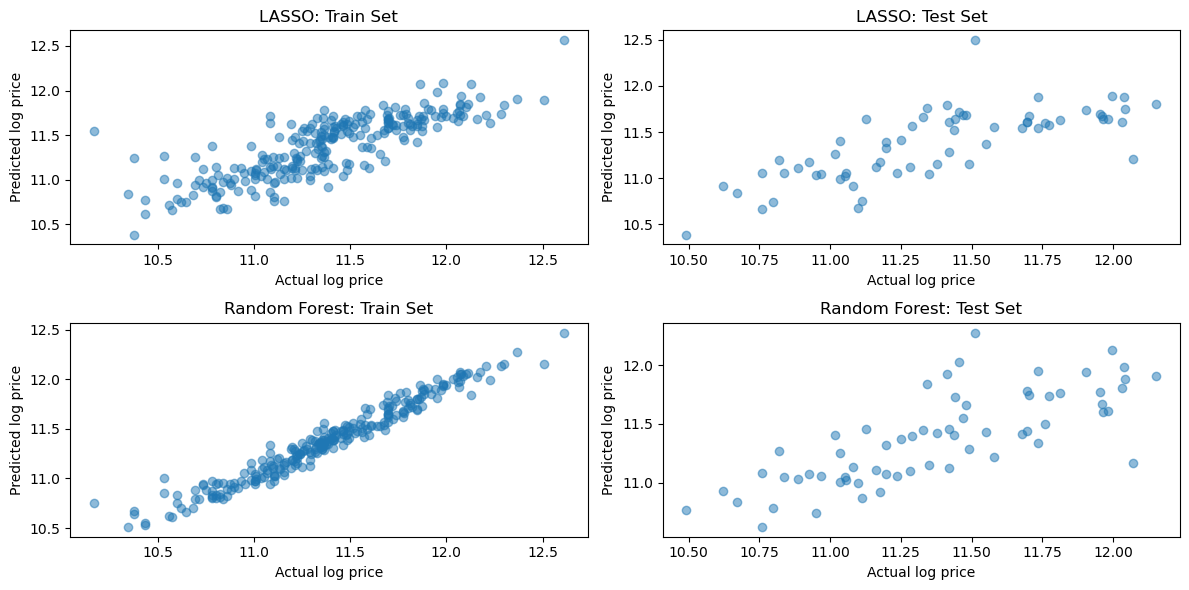

In [62]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Make predictions
y_pred_train_lasso = pipeline_lasso.predict(X_train)
y_pred_test_lasso = pipeline_lasso.predict(X_test)

y_pred_train_rf = pipeline_rf.predict(X_train)
y_pred_test_rf = pipeline_rf.predict(X_test)

# Evaluate the models
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)

mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)

print(f"MSE on train set for LASSO: {mse_train_lasso}")
print(f"MSE on test set for LASSO: {mse_test_lasso}")

print(f"MSE on train set for Random Forest: {mse_train_rf}")
print(f"MSE on test set for Random Forest: {mse_test_rf}")

# Plot the predictions
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].scatter(y_train, y_pred_train_lasso, alpha=0.5)
ax[0, 0].set_title('LASSO: Train Set')
ax[0, 0].set_xlabel('Actual log price')
ax[0, 0].set_ylabel('Predicted log price')

ax[0, 1].scatter(y_test, y_pred_test_lasso, alpha=0.5)
ax[0, 1].set_title('LASSO: Test Set')
ax[0, 1].set_xlabel('Actual log price')
ax[0, 1].set_ylabel('Predicted log price')

# Plot the predictions
ax[1, 0].scatter(y_train, y_pred_train_rf, alpha=0.5)
ax[1, 0].set_title('Random Forest: Train Set')
ax[1, 0].set_xlabel('Actual log price')
ax[1, 0].set_ylabel('Predicted log price')

ax[1, 1].scatter(y_test, y_pred_test_rf, alpha=0.5)
ax[1, 1].set_title('Random Forest: Test Set')
ax[1, 1].set_xlabel('Actual log price')
ax[1, 1].set_ylabel('Predicted log price')

plt.tight_layout()
plt.show()




## Interpretability - Identifying Important Predictors
LASSO inherently performs feature selection by shrinking some coefficients to zero. Random Forest, on the other hand, provides feature importance scores.

Let's identify which variables are the most significant predictors for each model.



In [68]:
# Get feature names for polynomial features
num_original_features_names = ['age', 'area', 'land', 'dist', 'rooms']
poly_features_names = preprocessor.named_transformers_['num']['poly'].get_feature_names_out(input_features=num_original_features_names)

# Get feature names for one-hot encoded features
cat_features_names = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=['baths'])

# Concatenate to get final feature names
final_feature_names = np.concatenate([poly_features_names, cat_features_names])

# Get feature importances from the fitted random forest model
feature_importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Map feature importances to feature names
feature_importance_mapping = dict(zip(final_feature_names, feature_importances))

# Sort by importance
sorted_features = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"{feature}: {importance}")


area: 0.32000017891919297
baths_3.0: 0.1343355507248138
age area: 0.0850816151633701
age: 0.07715881220410109
land: 0.040392338219760654
land dist: 0.03445052579219027
age dist: 0.03284143868696709
dist^2: 0.02890675736832877
land rooms: 0.02618455272902489
area rooms: 0.025139752500929015
area land: 0.023444866372656584
dist: 0.02304916506154113
age land: 0.022602294400171998
dist rooms: 0.021405056952035078
age rooms: 0.021298753404030334
area dist: 0.021062974059717545
land^2: 0.016343655373463554
area^2: 0.015602997595683305
age^2: 0.01082526256925833
baths_2.0: 0.007577742203289637
rooms: 0.004891911394774546
baths_1.0: 0.004111282937080661
rooms^2: 0.003182649817246454
baths_4.0: 0.00010986555037236265


In [70]:
# Get coefficients from the fitted random forest model
coefs = pipeline_lasso.named_steps['regressor'].coef_

# Map feature importances to feature names
feature_importance_mapping = dict(zip(final_feature_names, coefs))

# Sort by importance
sorted_features = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)

for feature, coefs in sorted_features:
    print(f"{feature}: {coefs}")


area: 0.18896330414591286
baths_3.0: 0.1429034073168659
age dist: 0.042412419432982594
rooms: 0.034091862933122254
age rooms: 0.018834569232854554
area land: 0.011232553002221113
area rooms: 0.009885626656448635
land: 0.005731758004550082
age land: 0.003639715168539355
land^2: 0.00016708232260003177
dist: -0.0
age^2: 0.0
area^2: 0.0
area dist: 0.0
land rooms: 0.0
baths_1.0: -0.0
baths_2.0: -0.0
baths_4.0: -0.0
rooms^2: -0.0018649220513631158
age area: -0.0035075783209376757
dist^2: -0.01310340992008904
dist rooms: -0.014940312815113627
land dist: -0.04235974863731979
age: -0.12029639718465568
